In [1]:
import sys
sys.path.append('..')

import re
import json
import numpy as np
import matplotlib.pyplot as plt

from music21.note import Note
from datetime import datetime
from tqdm.notebook import tqdm
from collections import OrderedDict, defaultdict

from source.constants import THEORYTAB_DATASET_FILEPATH, COMPLEXITIES

# TheoryTab Dataset

The [TheoryTab Database](https://www.hooktheory.com/theorytab) is a database built by HookTheory having *TheoryTabs* for a lot of popular songs.

A *TheoryTab* is similar to a guitar tab, but also displays each chord's function within the music and notes, revealing structures that may not be readily apparent. It can also be synchronized with a YouTube's video, which lets the user track each chord function in real time.

<div style="text-align: center;">
    <img src="../resources/images/The Beatles - Hey Jude (Verse).png" alt="The Beatles - Hey Jude (Verse) TheoryTab" width="480">
</div>
<br>

A crawler was created to crawl the TheoryTab DB website in order to collect the provided crowdsourced roman numeral analysis, or chord function analysis, and other information related to the collected songs, such as genre, contributors and [song metrics](https://www.hooktheory.com/song-metrics/about), such as chord and melody complexity, calculated internally by HookTheory themselves.

After the crawling process, which took around 3 days to complete, the dumped dataset was processed using the `process_dumped_theorytab_db.py` script. This script organized the collected data to be indexed by the song's section ID and also standardized the information, since the website changed and improved how the community provided the analysis through the years.

This notebooks serves the purpose to build a *ready-to-use*, MIR friendly, **TheoryTab Dataset** based on the processed TheoryTab  DB dump.

# Loading and analysing processed TheoryTab DB dump

In [ ]:
with open('<insert-path>', 'r') as fp:
    db = json.load(fp)

print('Number of theorytabs in processed TheoryTab DB:', len(db))

Number of theorytabs in processed TheoryTab DB: 54076


In [3]:
def print_header(theorytab_id: str, title: str = 'Processed TheoryTab'):
    info = db[theorytab_id]['hooktheory']
    header = f"{title} for \"{info['artist']} - {info['song']} ({info['section']})\""
    theorytab_url = info['theorytab_url']

    max_len = max(len(header), len(theorytab_url))
    header = header.center(max_len)
    theorytab_url = theorytab_url.center(max_len)
    
    print(' '+ '-' * (2 + max_len))
    print('| ' + ' ' * max_len + ' |')
    print('| ' + header + ' |')
    print('| ' + theorytab_url + ' |')
    print('| ' + ' ' * max_len + ' |')
    print(' ' + '-' * (2 + max_len))
    print()

In [4]:
hey_jude_verse_id = 'Rzoj_pYQmDe'

print_header(hey_jude_verse_id)
print(json.dumps(db[hey_jude_verse_id], indent=2))

 ----------------------------------------------------------------------
|                                                                      |
|       Processed TheoryTab for "The Beatles - Hey Jude (Verse)"       |
| https://www.hooktheory.com/theorytab/view/the-beatles/hey-jude#verse |
|                                                                      |
 ----------------------------------------------------------------------

{
  "num_beats": 32,
  "youtube": {
    "id": "A_MjCqQoLLA",
    "start_sync": 0.11671545984420233,
    "end_sync": 0.16887274480521205
  },
  "notes": [
    {
      "sd": "3",
      "octave": -1,
      "onset": 0,
      "offset": 2
    },
    {
      "sd": "3",
      "octave": -1,
      "onset": 2.5,
      "offset": 3.0
    },
    {
      "sd": "5",
      "octave": -1,
      "onset": 3,
      "offset": 3.5
    },
    {
      "sd": "6",
      "octave": -1,
      "onset": 3.5,
      "offset": 4.0
    },
    {
      "sd": "2",
      "octave": -1,
      "onset

As we can see above, each TheoryTab was processed as a JSON object, containing information about the number of beats of that tab through the `num_beats` key, YouTube related information through the `youtube` key and information about notes, chords, keys, tempos and meters, being self-descriptive objects. We also have "HookTheory information" through the `hooktheory` key, which stores the tab's genres, annotators, metrics, modified date, and other things.

Some important things to note are:

1. The YouTube's `start_sync` and `end_sync` informations are encoded as a percentage of the duration of the whole song if they are in the range $[0, 1]$, else they represent the synchronization in seconds. In this case, this excerpt of Hey Jude starts roughly at `duration * start_sync` and ends roughly at `duration * end_sync`. Of course that this information is approximate and potentially has human imprecision associated with it. To mitigate this effect, *Donahue et al.*, which also used TheoryTab DB's data to train the [SheetSage](https://arxiv.org/pdf/2212.01884), proposed an alignment processing step using a beat tracker to increase the precision of this information.

2. A note's `sd` information, meaning scale degree, can have $\sharp$ and $\flat$ indicating sharps and flats and also letters like *f*, *s* and *x* indicating flats, sharps and double-sharps.

3. A note's `octave` information is actually a relative octave, since TheoryTabs use this type of encoding when dealing with melody. In our case, when we see `octave: 0` and `octave: -1` we only know that the second one is lower than the first, but we doesn't know in which absolute octave this is being played.

4. A chord's `root` will vary between 1 and 7 and any values that does not respect this range are considered incorrect chord information, which commonly occured in early stages of TheoryTab annotation.

5. A chord's `applied` information will be a value between 0 and 7, where 0 means no applied. This information, in conjunction with `root`, builds what is called secondary chords, like $\text{V}/\text{IV}$. In this case, given TheoryTabs' internal organization, the applied and root information will be exchanged, meaning that in a $\text{V}/\text{IV}$ (*"five of four"*) chord, the *"four"*, which is the applied information, will be represented by the `root` key and the *"five"*, which is the root information, will be represented by the `applied` key.
   
7. A chord's `borrowed` information will encode if the chord is borrowed from a different scale/mode. If `borrowed` is a string, then the chord is borrowed from one of the next scales/modes: *major*, *dorian*, *phrygian*, *lydian*, *mixolydian*, *minor*, *locrian*, *harmonic minor* or *phrygian dominant*. If `borrowed` is a list, then it represents the pitch classes of the used scale **starting** from the current key tonic pitch class, i.e. we must add the key tonic pitch class to this borrowed information to get the borrowed scale pitch classes. The `borrowed` key can also be null, meaning that no borrowment was done.

8. A tempo's `swing_factor` information will be a value between 0.5 and 0.75 indicating how much swing is put in the song. Tipically this key is set to 0, indicating no swing. The `swing_factor` doesn't affect the annotation per say, but it does change when a note is played, and therefore, heard by the listener. The same can be said about the `swing_beat`, indicating which note should be used for the swing, where 0.5 is a 8th note and 0.25 a 16th note.

9. A meter's `beat_unit` information will be either 1 or 3, and this is enabled accordingly to the `beats_in_measure`, which is self explanatory. A `beat_unit` of 1 is the typical quarter note, or a crochet; and 3, which is only possible when `beats_in_measure` is 3, 6, 9 or 12, is used to represent each quarter note as a triplet, in other words, a note with 1/3 of its original duration.

## Removing duplicated TheoryTabs

A TheoryTab will be considered duplicated if the string `<artist> -- <song> [<section>]` appears more than once. If that is the case, the TheoryTab with the most recent `modified_date` attribute will be considered as the one to be used.

In [5]:
seen_theorytabs = {}

for theorytab_id, theorytab in db.items():
    songname = f"{theorytab['hooktheory']['artist']} -- {theorytab['hooktheory']['song']} [{str(theorytab['hooktheory']['section'])}]"

    if songname not in seen_theorytabs:
        seen_theorytabs[songname] = {
            'theorytab_id': theorytab_id,
            'modified_date': datetime.fromisoformat(theorytab['hooktheory']['modified_date'])
        }
    else:
        stored_date = seen_theorytabs[songname]['modified_date']
        current_date = datetime.fromisoformat(theorytab['hooktheory']['modified_date'])

        print(f'Found duplicate for {songname}')
        if current_date > stored_date:
            print(f"  - changing theorytab_id from {seen_theorytabs[songname]['theorytab_id']} to {theorytab_id}")
            print(f"  - changing modified date from {stored_date} to {current_date}\n")

            seen_theorytabs[songname]['theorytab_id'] = theorytab_id
            seen_theorytabs[songname]['modified_date'] = current_date
        else:
            print('  - this duplicate has older information\n')

Found duplicate for Tommaso Giordani -- Caro Mio Ben [Intro]
  - changing theorytab_id from YAg-zQzwxle to nLgakaWloYp
  - changing modified date from 2023-05-05 19:13:16+00:00 to 2023-05-07 19:02:30+00:00

Found duplicate for Tom Petty And The Heartbreakers -- I Won't Back Down [Verse]
  - changing theorytab_id from nZgWrMBEmry to QLgnqDjpm-V
  - changing modified date from 2020-04-14 03:41:08+00:00 to 2023-10-25 13:40:15+00:00

Found duplicate for OneRepublic -- Counting Stars [Intro]
  - this duplicate has older information

Found duplicate for Smashing Pumpkins -- Bullet With Butterfly Wings [Intro and Verse]
  - changing theorytab_id from nZgWrNdBmry to dPoDYZBqmnM
  - changing modified date from 2020-04-20 00:37:42+00:00 to 2024-06-23 00:49:18+00:00

Found duplicate for Taylor Swift -- Call It What You Want [Chorus]
  - changing theorytab_id from QLgnjjqvg-V to RPxenKpPob_
  - changing modified date from 2018-07-10 19:48:53+00:00 to 2020-09-30 10:24:37+00:00



In [6]:
original_db_size = len(db)
db = {info['theorytab_id']: db[info['theorytab_id']] for info in seen_theorytabs.values()}

print('Number of TheoryTabs in original TheoryTab DB:', original_db_size)
print('Number of TheoryTabs in filtered TheoryTab DB:', len(db))

Number of TheoryTabs in original TheoryTab DB: 54076
Number of TheoryTabs in filtered TheoryTab DB: 54071


## Removing sections without beats

In [7]:
db = {theorytab_id: theorytab for theorytab_id, theorytab in db.items() if theorytab['num_beats'] != 0}

print('Number of TheoryTabs in original TheoryTab DB:', original_db_size)
print('Number of TheoryTabs in filtered TheoryTab DB:', len(db))

Number of TheoryTabs in original TheoryTab DB: 54076
Number of TheoryTabs in filtered TheoryTab DB: 54068


# Building the dataset

As mentioned in the beginning of this notebook, we are going to build a *ready-to-use*, MIR friendly, **TheoryTab Dataset** based on the processed TheoryTab  DB dump. And, to do so, we must parse all the important information from each one of the keys that a processed *TheoryTab* offers.

Besides that, each parsed *TheoryTab* will have its beats information changed from quarter notes to 32nd notes (or *demisemiquavers*). In other words, all beat related information will be multiplied by 8. In case of non integer multiplications, such as when triplets happen, we will round that value to the nearest integer.

This resolution hyperparameter can be changed and tuned via the `BEAT_RESOLUTION` variable.

<!-- Besides that, each parsed *TheoryTab* will have a list of tags that summarize that *TheoryTab*, like for example: if a song has melody, harmony, has swing factor, has key changes, among others. -->

In [8]:
BEAT_RESOLUTION = 8  # 1: quarter notes, 2: 8th notes, 4: 16th notes, 8: 32nd notes
assert BEAT_RESOLUTION in (1, 2, 4, 8)

theorytab_dataset = {}
for theorytab_id, theorytab in tqdm(db.items()):
    assert isinstance(theorytab['num_beats'], int)
    
    theorytab_dataset[theorytab_id] = {}
    theorytab_dataset[theorytab_id]['num_beats'] = BEAT_RESOLUTION * theorytab['num_beats']
    theorytab_dataset[theorytab_id]['hooktheory'] = theorytab['hooktheory']
    theorytab_dataset[theorytab_id]['youtube'] = theorytab['youtube']
    theorytab_dataset[theorytab_id]['tags'] = theorytab['tags']

print('TheoryTab Dataset size:', len(theorytab_dataset))

  0%|          | 0/54068 [00:00<?, ?it/s]

TheoryTab Dataset size: 54068


## Parsing keys

Each *TheoryTab* `keys` object is going to be a list with dictionaries containing:
1. The key's onset/offset beats;
2. The key's scale, being one of the following: *major*, *dorian*, *phrygian*, *lydian*, *mixolydian*, *minor*, *locrian*, *harmonic minor* or *phrygian dominant*
3. The key's tonic, which can be any of the 12 pitches with an $\sharp$ or $\flat$ added.

The parsed *TheoryTab* `keys` object is going to be a list with dictionaries containing:
1. The key's onset/offset beats in 32nd notes (or demisemiquavers).
2. The key's scale name;
3. The key's scale intervals in semitones, e.g. the major scale will be `[2, 2, 1, 2, 2]`. This mapping will be stored in a look-up table called `SCALE_INTERVALS`.
4. The key's tonic pitch class, which gets rid of enharmonic keys and other problems.
5. The key's scale pitch classes, which is the application of the intervals starting from a tonic note.

In [9]:
def get_note_name(pc):
    return Note(pc).name

def get_note_pitch_class(note):
    note = note.replace('b', '-')
    return Note(note).pitch.pitchClass

SCALE_INTERVALS = {
    'major': [2, 2, 1, 2, 2, 2],
    'dorian': [2, 1, 2, 2, 2, 1],
    'phrygian': [1, 2, 2, 2, 1, 2],
    'lydian': [2, 2, 2, 1, 2, 2],
    'mixolydian': [2, 2, 1, 2, 2, 1],
    'minor': [2, 1, 2, 2, 1, 2],
    'locrian': [1, 2, 2, 1, 2, 2],
    'harmonicMinor': [2, 1, 2, 2, 1, 3],
    'phrygianDominant': [1, 3, 1, 2, 1, 2]
}

base_notes = ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'A', 'E']
for idx, (scale, intervals) in enumerate(SCALE_INTERVALS.items()):
    base_note_pc = get_note_pitch_class(base_notes[idx])
    scale_notes = [get_note_name(pc) for pc in np.cumsum([base_note_pc] + intervals)]
    print(f'{base_notes[idx]} {scale} notes: {scale_notes}')

C major notes: ['C', 'D', 'E', 'F', 'G', 'A', 'B']
D dorian notes: ['D', 'E', 'F', 'G', 'A', 'B', 'C']
E phrygian notes: ['E', 'F', 'G', 'A', 'B', 'C', 'D']
F lydian notes: ['F', 'G', 'A', 'B', 'C', 'D', 'E']
G mixolydian notes: ['G', 'A', 'B', 'C', 'D', 'E', 'F']
A minor notes: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
B locrian notes: ['B', 'C', 'D', 'E', 'F', 'G', 'A']
A harmonicMinor notes: ['A', 'B', 'C', 'D', 'E', 'F', 'G#']
E phrygianDominant notes: ['E', 'F', 'G#', 'A', 'B', 'C', 'D']


In [10]:
def parse_theorytab_keys(theorytab_id):
    parsed_keys = []

    for key in db[theorytab_id]['keys']:
        onset = round(BEAT_RESOLUTION * key['onset'])
        offset = round(BEAT_RESOLUTION * key['offset'])

        scale_intervals = SCALE_INTERVALS[key['scale']]
        tonic_pitch_class = get_note_pitch_class(key['tonic'])
        
        scale_pitch_classes = np.cumsum([tonic_pitch_class] + scale_intervals) % 12
        scale_pitch_classes = scale_pitch_classes.tolist()

        assert scale_pitch_classes[0] == tonic_pitch_class
        assert (np.diff(scale_pitch_classes) % 12).tolist() == scale_intervals
        
        parsed_keys.append({
            'onset': onset,
            'offset': offset,
            'scale': key['scale'],
            'scale_intervals': scale_intervals,
            'tonic_pitch_class': tonic_pitch_class,
            'scale_pitch_classes': scale_pitch_classes
        })

    return parsed_keys

In [11]:
for theorytab_id, theorytab in tqdm(db.items()):
    theorytab_dataset[theorytab_id]['keys'] = parse_theorytab_keys(theorytab_id)

print_header(hey_jude_verse_id, title='Parsed keys')
print(json.dumps(theorytab_dataset[hey_jude_verse_id]['keys'], indent=2))

  0%|          | 0/54068 [00:00<?, ?it/s]

 ----------------------------------------------------------------------
|                                                                      |
|           Parsed keys for "The Beatles - Hey Jude (Verse)"           |
| https://www.hooktheory.com/theorytab/view/the-beatles/hey-jude#verse |
|                                                                      |
 ----------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 256,
    "scale": "major",
    "scale_intervals": [
      2,
      2,
      1,
      2,
      2,
      2
    ],
    "tonic_pitch_class": 5,
    "scale_pitch_classes": [
      5,
      7,
      9,
      10,
      0,
      2,
      4
    ]
  }
]


## Parsing notes

Each *TheoryTab* `notes` object is going to be a list with dictionaries containing:
1. The note's onset/offset beats;
2. The note's scale degree (`sd`), scale, which can be an integer $d \in [1, 7]$ with an $\sharp$, $\flat$ and $\times$ (double-sharp). Besides this, we can have the letters `f` and `s` indicanting a flat and a sharp note.
3. The note's octave, which canis a relative octave information as discussed previously.

The parsed *TheoryTab* `notes` object is going to be a list with dictionaries containing:
1. The note's onset/offset beats in 32nd notes (or demisemiquavers).
2. The note's pitch class, which gets rid of enharmonic notes and other problems;
3. The note's relative octave information.

In [12]:
def parse_scale_degree(notation):
    match = re.match(r"([x#b]*)(\d+)([fs]*)", notation)
    if not match:
        raise ValueError(f'Unexpected {notation = } (no match in regular expression)')

    prefix, scale_degree, suffix = match.groups()

    if prefix and suffix:
        raise ValueError(f'Unexpected {notation = } (has both prefix and suffix)')

    # Normalize accidental
    accidental_map = {'f': 'b', 's': '#', 'x': '##'}
    accidental = accidental_map.get(prefix, prefix)  # either get the prefix or convert x into ##
    
    if not prefix:  # If no prefix, check suffix mapping
        accidental = accidental_map.get(suffix, '')

    return int(scale_degree), accidental

def get_current_key(keys, onset, offset):
    for key in keys:
        if onset >= key['onset'] and offset <= key['offset']:
            return key
    
    raise ValueError(f'Unable to find key in between ({onset=}, {offset=}) [{keys=}]')

def parse_theorytab_notes(theorytab_id):
    parsed_notes = []

    for note in db[theorytab_id]['notes']:
        onset = round(BEAT_RESOLUTION * note['onset'])
        offset = round(BEAT_RESOLUTION * note['offset'])

        scale_degree, accidental = parse_scale_degree(note['sd'])
        current_key = get_current_key(theorytab_dataset[theorytab_id]['keys'], onset, offset)

        note_pitch_class = current_key['scale_pitch_classes'][scale_degree - 1]
        note_pitch_class = note_pitch_class + (accidental.count('#') - accidental.count('b'))

        parsed_notes.append({
            'onset': onset,
            'offset': offset,
            'octave': note['octave'],
            'note_pitch_class': note_pitch_class
        })

    return parsed_notes

In [13]:
for theorytab_id, theorytab in tqdm(db.items()):
    theorytab_dataset[theorytab_id]['notes'] = parse_theorytab_notes(theorytab_id)
    
print_header(hey_jude_verse_id, title='Parsed notes')
print(json.dumps(theorytab_dataset[hey_jude_verse_id]['notes'], indent=2))

  0%|          | 0/54068 [00:00<?, ?it/s]

 ----------------------------------------------------------------------
|                                                                      |
|          Parsed notes for "The Beatles - Hey Jude (Verse)"           |
| https://www.hooktheory.com/theorytab/view/the-beatles/hey-jude#verse |
|                                                                      |
 ----------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 16,
    "octave": -1,
    "note_pitch_class": 9
  },
  {
    "onset": 20,
    "offset": 24,
    "octave": -1,
    "note_pitch_class": 9
  },
  {
    "onset": 24,
    "offset": 28,
    "octave": -1,
    "note_pitch_class": 0
  },
  {
    "onset": 28,
    "offset": 32,
    "octave": -1,
    "note_pitch_class": 2
  },
  {
    "onset": 32,
    "offset": 48,
    "octave": -1,
    "note_pitch_class": 7
  },
  {
    "onset": 56,
    "offset": 60,
    "octave": -1,
    "note_pitch_class": 7
  },
  {
    "onset": 60,
    "offset":

In [14]:
# Checking on another more complicated TheoryTab
another_day_of_sun_chorus_id = 'Abm_dYOAgak'

print_header(another_day_of_sun_chorus_id, title='Parsed notes')
print(json.dumps(theorytab_dataset[another_day_of_sun_chorus_id]['notes'], indent=2))

 ------------------------------------------------------------------------------------
|                                                                                    |
|          Parsed notes for "Justin Hurwitz - Another Day Of Sun (Chorus)"           |
| https://www.hooktheory.com/theorytab/view/justin-hurwitz/another-day-of-sun#chorus |
|                                                                                    |
 ------------------------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 8,
    "octave": -1,
    "note_pitch_class": 0
  },
  {
    "onset": 8,
    "offset": 16,
    "octave": 0,
    "note_pitch_class": 3
  },
  {
    "onset": 16,
    "offset": 24,
    "octave": 0,
    "note_pitch_class": 8
  },
  {
    "onset": 24,
    "offset": 30,
    "octave": 0,
    "note_pitch_class": 0
  },
  {
    "onset": 30,
    "offset": 36,
    "octave": 0,
    "note_pitch_class": 10
  },
  {
    "onset": 36,
    "offset": 40,
    

## Parsing chords

Each *TheoryTab* `chords` object is going to be a list with dictionaries containing:
1. The chord's onset/offset beats;
2. The chord's root information, which will be an integer $r \in [1, 7]$ meaning the scale degree in which that chord is built;
3. The chord's type information, which will be an integer $t \in \{5, 7, 9, 11, 13\}$ meaning if the chord is a triad (5), a 7th chord (7), and so on;
4. The chord's inversion information, which will be an integer $i \in \{0, 1, 2, 3\}$ meaning if the chord has no inversion (0), first inversion (1), and so on;
5. The chord's applied information, which will be an integer $a \in [0, 7]$ meaning the scale degree in which the tonicization is happening, where 0 means no tonicization;
6. The chord's "add" information, which will be a list with a combination of: $4$ (add9), $6$ (add11) and $9$ (add13);
7. The chord's "omitted" information, which will be a list with a combination of: $3$ (no3) and $5$ (no5);
8. The chord's "alterations" information, which will be a list with a combination of: $\flat5$, $\sharp5$, $\flat9$, $\sharp9$, $\sharp11$ and $\flat13\}$;
9. The chord's "suspensions" information, which will be a list with a combination of: $2$ (sus2) and $4$ (sus4);
10. The chord's "substitutions" information, which will be a list possibly with the string `tri` meaning that we have a tritone substitution (pitch shift of $\pm6$ semitones) and this only happens if `applied = 5`;
11. The chord's "borrowed" information, which will encode if the chord is borrowed from a different scale/mode. If `borrowed` is a string, then the chord is borrowed from one of the previously mentioned key scales. If `borrowed` is a list, then it represents the pitch classes of the used scale **starting** from the current key tonic pitch class, i.e. we must add the key tonic pitch class to this borrowed information to get the borrowed scale pitch classes. The `borrowed` key can also be null, meaning that no borrowment was done.

   
The parsed *TheoryTab* `chords` object is going to be a list with dictionaries containing:
1. The chord's onset/offset beats in 32nd chords (or demisemiquavers);
2. The chord's primary degree being a string from 1 through 7 with possibly $\flat$ or $\sharp$ from borrowed information;
3. The chord's secondary degree being a string from 1 through 7 (in *TheoryTabs* the secondary degree will always be a diatonic chord);
4. The chord's interval content, like the scale intervals, representing its quality, e.g. `(4, 3, 4)` is a major 7th chord;
5. The chord's inversion information, just like the original one;
6. The chord's root pitch class;
7. The chord's bass pitch class;
8. The chord's tonicized pitch class, which will be the same as the key tonic pitch class if no tonicization happened;
9. The chord's degree roman numeral, which is going to be the joint information of the primary degree and secondary degree with a Roman Numeral (RN) syntax where uppercase numerals represent major chords, lowercase minor chords, $+$ augmented and $^\text{o}$ diminished. This representation will **not** have inversion information and will only deal with triads or 7th chords, because in most cases other information doesn't necessary change a chord's function in the progression.

**Important Note$^1$:** One must be cautious with the chord's `applied` information, since this can change its local key by means of tonicization. In this case, the local key will be a major key with the `root` information of the chord as the new tonic and the `applied` information as the new root. For example, with a weird chord like $\text{iii}/\sharp\text{v}\degree$, in C major, we must first setup the new key as G# major, which corresponds to the $\sharp\text{v}$ degree in C major, and pick the third chord of that scale, which is going to be a $\text{B}\sharp\text{m}$, equivalent to $\text{Cm}$, chord.

**Important Note$^2$:** We could try to retrieve the quality information through [interval class vectors](https://musictheory.pugetsound.edu/mt21c/IntervalVector.html) or [Forte numbers](https://en.wikipedia.org/wiki/Forte_number), which basically describes or maps the intervallic content of a chord into a compact representation. However, when dealing with such representation, some chords may clash, like the major and minor triad which share the same interval class vector (`<001110>`). When dealing with Forte numbers, we can add the "inversion" concept, distinguishing chords with the same arrange of intervals but in a different order, like `3-11A` for minor triad and `3-11B` for major triad, since they share the same intervals but in a inverted order. However, we would need to rely on the pre-mapped qualities and if we find a Forte number that doesn't have a mapped quality name, the inverse transformation is going to be really hard and basically trial and error. This is because both maps were developed with an atonal analysis perspective, disregarding the necessity to trully understand the tonal aspects of a piece of music.

**Important Note$^3$:** Given the way that HookTheory deals with RN syntax, the degrees don't have an accidental figure except when a borrowment occurs. In this case, to retrieve such accidentals, we just need to do the following: `borrowed_scale_pitches - key_scale_pitches`. We will get an array with 7 elements from this subtraction, where each will be one of the following: $-2$ (double-flat), $-1$ (flat), $0$ (no accidental), $+1$ (sharp) and $+2$ (double-sharp). In this context, pitches are the same as pitch classes but without the $\mod 12$ to avoid miscalculations.

In [15]:
def get_chord_local_key(chord, keys, **kwargs):
    key = get_current_key(keys, **kwargs)

    scale_intervals = key['scale_intervals']
    tonic_pitch_class = key['tonic_pitch_class']

    if isinstance(chord['borrowed'], list):
        scale_pitch_classes = (tonic_pitch_class + np.array(chord['borrowed'])) % 12
        tonic_pitch_class = scale_pitch_classes[0]
    else:
        if chord['borrowed'] in SCALE_INTERVALS:
            scale_intervals = SCALE_INTERVALS[chord['borrowed']]

        scale_pitch_classes = np.cumsum([tonic_pitch_class] + scale_intervals) % 12
    
    scale_pitch_classes = scale_pitch_classes.tolist()
    assert len(scale_pitch_classes) == 7

    if chord['applied'] > 0:
        tonic_pitch_class = scale_pitch_classes[chord['root'] - 1]
        scale_pitch_classes = np.cumsum([tonic_pitch_class] + SCALE_INTERVALS['major']) % 12
        scale_pitch_classes = scale_pitch_classes.tolist()
    
    return key, tonic_pitch_class, scale_pitch_classes

def get_chord_degrees(chord):
    chord_degrees = set(range(1, chord['type'] + 1, 2))
    
    for idx, degree in enumerate(chord['suspensions']):
        if idx == 0:  # only remove 3rd degree once
            assert 3 in chord_degrees
            chord_degrees.remove(3)
    
        assert degree not in chord_degrees
        chord_degrees.add(degree)

    for degree in chord['adds']:
        if degree in [4, 6]:
            degree += 7  # add11 and add13 information were mod7
        
        chord_degrees.add(degree)

    for degree in chord['omits']:
        assert degree in [3, 5]
        assert degree in chord_degrees
        chord_degrees.remove(degree)
        
    for alt in chord['alterations']:
        degree = int(alt[1:])
        chord_degrees.add(degree)  # further, we will apply alterations directly on pitch classes
    
    return sorted(list(chord_degrees))

def get_chord_pitch_informations(chord, scale_pitch_classes):
    chord_degrees = get_chord_degrees(chord)
    root = chord['root'] if chord['applied'] == 0 else chord['applied']

    chord_degree_to_pitch_class = OrderedDict()
    for degree in chord_degrees:
        degree_index = (root - 1) + (degree - 1)
        chord_degree_to_pitch_class[degree] = scale_pitch_classes[degree_index % 7]
        
        if degree == 7 and chord['applied'] == 7:
            chord_degree_to_pitch_class[degree] -= 1  # in HookPad this case is actually a o7 and not m7

    for alt in chord['alterations']:
        degree = int(alt[1:])
        assert degree in chord_degree_to_pitch_class
        chord_degree_to_pitch_class[degree] += 1 if alt[0] == '#' else -1
    
    # Transposing the chord pitch offset information to the correct key
    # If a tritone substitution is used, we are going to alter the pitch classes by +6 (could be -6)
    if 'tri' in chord['substitutions']:
        for degree, pitch_class in chord_degree_to_pitch_class.items():
            chord_degree_to_pitch_class[degree] = 6 + pitch_class

    chord_pitch_classes = list(chord_degree_to_pitch_class.values())
    
    # Extracting informations of the chord based on its pitch offsets
    root_pitch_class = chord_pitch_classes[0] % 12
    chord_intervals = tuple(filter(lambda x: x != 0, (np.diff(chord_pitch_classes) % 12).tolist()))

    # Extracting bass note pitch class
    inversion_degree = 2 * chord['inversion'] + 1
    if chord['inversion'] == 1 and 2 in chord['suspensions']:
        inversion_degree -= 1
    elif chord['inversion'] == 1 and chord['suspensions'] == [4]:
        inversion_degree += 1
    
    if inversion_degree not in chord_degree_to_pitch_class:
        print(chord['inversion'], inversion_degree)
        print(chord_degrees, chord_degree_to_pitch_class)
        print(chord)
        raise ValueError('Inversion not found in offsets')

    bass_pitch_class = chord_degree_to_pitch_class[inversion_degree] % 12
    return root_pitch_class, bass_pitch_class, chord_intervals

def get_borrowed_accidentals(key, borrowed):
    if not borrowed:
        return 7 * ['']
        
    key_scale_pitches = np.cumsum([key['tonic_pitch_class']] + key['scale_intervals'])

    if isinstance(borrowed, list):
        borrowed_scale_pitches = key['tonic_pitch_class'] + np.array(borrowed)
    elif borrowed in SCALE_INTERVALS:
        borrowed_scale_pitches = np.cumsum([key['tonic_pitch_class']] + SCALE_INTERVALS[borrowed])
    else:
        raise ValueError(f'Unexpected {borrowed = }')

    accidental_map = {-2: 'bb', -1: 'b', 0: '', 1: '#', 2: '##'}
    pitch_differences = borrowed_scale_pitches - key_scale_pitches
    
    borrowed_accidentals = []
    for diff in pitch_differences:
        if diff not in accidental_map:
            diff = diff % 12

        borrowed_accidentals.append(accidental_map[diff])

    return borrowed_accidentals

def get_chord_rn(chord, scale_pitch_classes, borrowed_accidentals):
    roman_numerals = ['', 'I', 'ii', 'iii', 'IV', 'V', 'vi', 'vii']
    
    root, applied = chord['root'], chord['applied']
    root_rn, applied_rn = roman_numerals[root], roman_numerals[applied]

    # Determining applied quality
    if chord['applied'] == 7:
        applied_rn += 'o'

    applied_triad_quality = 'major' if applied_rn.isupper() else 'minor'
    if 'o' in applied_rn:
        applied_triad_quality = 'diminished'

    # Determining root quality
    root_pitch_class = scale_pitch_classes[root - 1]
    third_pitch_class = scale_pitch_classes[((root - 1) + 2) % 7]
    fifth_pitch_class = scale_pitch_classes[((root - 1) + 4) % 7]

    interval1 = (third_pitch_class - root_pitch_class) % 12
    interval2 = (fifth_pitch_class - third_pitch_class) % 12

    triad_map = {
        (4, 3): ('major', lambda x: x.upper()),
        (3, 4): ('minor', lambda x: x.lower()),
        (3, 3): ('diminished', lambda x: x.lower() + 'o'),
        (4, 4): ('augmented', lambda x: x.upper() + '+')
    }

    root_triad_quality, op = triad_map[(interval1, interval2)]
    
    root_rn = op(root_rn)
    root_rn = borrowed_accidentals[root - 1] + root_rn

    # Exchanging root with applied if needed
    if chord['applied'] != 0:
        root, applied = applied, root
        root_rn, applied_rn = applied_rn, root_rn
        root_triad_quality, applied_triad_quality = applied_triad_quality, root_triad_quality
        scale_pitch_classes = np.cumsum([scale_pitch_classes[0]] + SCALE_INTERVALS['major']) % 12

    if root_triad_quality == 'major' and '#5' in chord['alterations']:
        root_rn += '+'
    elif root_triad_quality == 'minor' and 'b5' in chord['alterations']:
        root_rn += 'o'

    # Dealing with tritone substitutions (only happens in V -> bII)
    if 'tri' in chord['substitutions'] and chord['applied'] == 5:
        root_rn = 'bII'
        root_triad_quality = 'major'
    
    # Handling 7th information
    if chord['type'] > 5:
        fifth_pitch_class = scale_pitch_classes[((root - 1) + 4) % 7]
        seventh_pitch_class = scale_pitch_classes[((root - 1) + 6) % 7]
        interval3 = (seventh_pitch_class - fifth_pitch_class) % 12
        
        # TODO: mudar isso para forma M7 e tals
        seventh_map = {
            ('major', 3): '7',
            ('major', 4): 'maj7',
            ('minor', 3): '7',
            ('minor', 4): 'maj7',
            ('diminished', 3): '7',
            ('diminished', 4): '7',
            ('augmented', 2): '7',
            ('augmented', 3): 'maj7'
        }

        root_rn += seventh_map[(root_triad_quality, interval3)]
        if root_triad_quality == 'diminished' and interval3 == 4 and chord['applied'] != 7:
            root_rn = root_rn.replace('o', '/o')

    if 'omaj7' in root_rn:
        chord_quality = 'oM7'
    elif '/o7' in root_rn:
        chord_quality = 'h7'
    elif 'o7' in root_rn:
        chord_quality = 'd7'
    elif 'o' in root_rn:
        chord_quality = 'd'
    elif '+maj7' in root_rn:
        chord_quality = 'aM7'
    elif '+7' in root_rn:
        chord_quality = 'a7'
    elif '+' in root_rn:
        chord_quality = 'a'
    elif root_triad_quality == 'major' and 'maj7' in root_rn:
        chord_quality = 'M7'
    elif root_triad_quality == 'major' and '7' in root_rn:
        chord_quality = 'D7'
    elif root_triad_quality == 'minor' and 'maj7' in root_rn:
        chord_quality = 'mM7'
    elif root_triad_quality == 'minor' and '7' in root_rn:
        chord_quality = 'm7'
    elif root_triad_quality == 'major':
        chord_quality = 'M'
    elif root_triad_quality == 'minor':
        chord_quality = 'm'
    else:
        raise ValueError(f'No quality found: {root_triad_quality = }, {root_rn = }')

    borrowed = '[bor]' if borrowed_accidentals != 7 * [''] else ''
    simple_rn = root_rn if chord['applied'] == 0 else f'{root_rn}/{applied_rn}'
    complete_rn = f"{root_rn}:{applied_rn}:{chord_quality}:{chord['inversion']}:{borrowed}"
    
    return simple_rn, complete_rn, chord_quality

Let's check the functions `get_borrowed_accidentals` and `get_chord_degree_rn` by generating the harmonic field of a scale and variating all possible borrowment strings.

In [16]:
key = {
    'tonic_pitch_class': get_note_pitch_class('C'),
    'scale_intervals': SCALE_INTERVALS['lydian']
}

for borrowed in SCALE_INTERVALS.keys():
    borrowed_accidentals = get_borrowed_accidentals(key, borrowed)
    scale_pitch_classes = (np.cumsum([key['tonic_pitch_class']] + SCALE_INTERVALS[borrowed]) % 12).tolist()
    
    chord_rns = []
    chord_rns_7th = []
    chord_rns_applied = []
    chord_rns_applied_7th = []
    chord_rns_tritone_sub = []
    
    for root in range(1, 8):
        chord = {'root': root, 'type': 5, 'applied': 0, 'inversion': 1, 'substitutions': [], 'alterations': []}
        chord_rns.append(get_chord_rn(chord, scale_pitch_classes, borrowed_accidentals))
        
        chord = {'root': root, 'type': 7, 'applied': 0, 'inversion': 1, 'substitutions': [], 'alterations': []}
        chord_rns_7th.append(get_chord_rn(chord, scale_pitch_classes, borrowed_accidentals))
        
        chord = {'root': root, 'type': 5, 'applied': 5, 'inversion': 1, 'substitutions': [], 'alterations': []}
        chord_rns_applied.append(get_chord_rn(chord, scale_pitch_classes, borrowed_accidentals))
        
        chord = {'root': root, 'type': 7, 'applied': 5, 'inversion': 1, 'substitutions': [], 'alterations': []}
        chord_rns_applied_7th.append(get_chord_rn(chord, scale_pitch_classes, borrowed_accidentals))
        
        chord = {'root': root, 'type': 5, 'applied': 5, 'inversion': 0, 'substitutions': ['tri'], 'alterations': []}
        chord_rns_tritone_sub.append(get_chord_rn(chord, scale_pitch_classes, borrowed_accidentals))
        
    print(f'{borrowed = } -> {chord_rns}')
    print(f'{borrowed = } with 7th -> {chord_rns_7th}')
    print(f'{borrowed = } applied -> {chord_rns_applied}')
    print(f'{borrowed = } applied with 7th -> {chord_rns_applied_7th}')
    print(f'{borrowed = } tritone sub -> {chord_rns_tritone_sub}')
    print()

borrowed = 'major' -> [('I', 'I::M:1:[bor]', 'M'), ('ii', 'ii::m:1:[bor]', 'm'), ('iii', 'iii::m:1:[bor]', 'm'), ('bIV', 'bIV::M:1:[bor]', 'M'), ('V', 'V::M:1:[bor]', 'M'), ('vi', 'vi::m:1:[bor]', 'm'), ('viio', 'viio::d:1:[bor]', 'd')]
borrowed = 'major' with 7th -> [('Imaj7', 'Imaj7::M7:1:[bor]', 'M7'), ('ii7', 'ii7::m7:1:[bor]', 'm7'), ('iii7', 'iii7::m7:1:[bor]', 'm7'), ('bIVmaj7', 'bIVmaj7::M7:1:[bor]', 'M7'), ('V7', 'V7::D7:1:[bor]', 'D7'), ('vi7', 'vi7::m7:1:[bor]', 'm7'), ('vii/o7', 'vii/o7::h7:1:[bor]', 'h7')]
borrowed = 'major' applied -> [('V/I', 'V:I:M:1:[bor]', 'M'), ('V/ii', 'V:ii:M:1:[bor]', 'M'), ('V/iii', 'V:iii:M:1:[bor]', 'M'), ('V/bIV', 'V:bIV:M:1:[bor]', 'M'), ('V/V', 'V:V:M:1:[bor]', 'M'), ('V/vi', 'V:vi:M:1:[bor]', 'M'), ('V/viio', 'V:viio:M:1:[bor]', 'M')]
borrowed = 'major' applied with 7th -> [('V7/I', 'V7:I:D7:1:[bor]', 'D7'), ('V7/ii', 'V7:ii:D7:1:[bor]', 'D7'), ('V7/iii', 'V7:iii:D7:1:[bor]', 'D7'), ('V7/bIV', 'V7:bIV:D7:1:[bor]', 'D7'), ('V7/V', 'V7:V:D7:1

Parsing all chords of the processed database.

In [17]:
def parse_theorytab_chords(theorytab_id):
    parsed_chords = []

    for chord in db[theorytab_id]['chords']:
        try:
            onset = round(BEAT_RESOLUTION * chord['onset'])
            offset = round(BEAT_RESOLUTION * chord['offset'])

            key, tonic_pitch_class, scale_pitch_classes = get_chord_local_key(chord, theorytab_dataset[theorytab_id]['keys'], onset=onset, offset=offset)
            
            borrowed_accidentals = get_borrowed_accidentals(key, chord['borrowed'])
            simple_rn, complete_rn, chord_quality = get_chord_rn(chord, scale_pitch_classes, borrowed_accidentals)
            root_pitch_class, bass_pitch_class, chord_intervals = get_chord_pitch_informations(chord, scale_pitch_classes)
    
            secondary_degree = str(chord['applied'])
            tonicized_pitch_class = int(tonic_pitch_class)
            primary_degree = borrowed_accidentals[chord['root'] - 1] + str(chord['root'])
        except:
            print(chord)
            print(key)
            raise
        
        parsed_chords.append({
            'onset': onset,
            'offset': offset,
            'primary_degree': primary_degree,
            'secondary_degree': secondary_degree,
            'inversion': chord['inversion'],
            'chord_intervals': chord_intervals,
            'root_pitch_class': root_pitch_class,
            'bass_pitch_class': bass_pitch_class,
            'tonicized_pitch_class': tonicized_pitch_class,
            'simple_rn': simple_rn,
            'complete_rn': complete_rn,
            'quality': chord_quality
        })
        
    return parsed_chords

In [18]:
for theorytab_id, theorytab in tqdm(db.items()):
    theorytab_dataset[theorytab_id]['chords'] = parse_theorytab_chords(theorytab_id)

  0%|          | 0/54068 [00:00<?, ?it/s]

In [19]:
print_header(hey_jude_verse_id, title='Parsed chords')
print(json.dumps(theorytab_dataset[hey_jude_verse_id]['chords'], indent=2))

 ----------------------------------------------------------------------
|                                                                      |
|          Parsed chords for "The Beatles - Hey Jude (Verse)"          |
| https://www.hooktheory.com/theorytab/view/the-beatles/hey-jude#verse |
|                                                                      |
 ----------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 32,
    "primary_degree": "1",
    "secondary_degree": "0",
    "inversion": 0,
    "chord_intervals": [
      4,
      3
    ],
    "root_pitch_class": 5,
    "bass_pitch_class": 5,
    "tonicized_pitch_class": 5,
    "simple_rn": "I",
    "complete_rn": "I::M:0:",
    "quality": "M"
  },
  {
    "onset": 32,
    "offset": 60,
    "primary_degree": "5",
    "secondary_degree": "0",
    "inversion": 0,
    "chord_intervals": [
      4,
      3
    ],
    "root_pitch_class": 0,
    "bass_pitch_class": 0,
    "tonicized_pit

In [20]:
# Checking on another more complicated TheoryTab
another_day_of_sun_verse_id = 'YAg-ZydKxle'

print_header(another_day_of_sun_verse_id, title='Parsed chords')
print(json.dumps(theorytab_dataset[another_day_of_sun_verse_id]['chords'], indent=2))

 -----------------------------------------------------------------------------------
|                                                                                   |
|          Parsed chords for "Justin Hurwitz - Another Day Of Sun (Verse)"          |
| https://www.hooktheory.com/theorytab/view/justin-hurwitz/another-day-of-sun#verse |
|                                                                                   |
 -----------------------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 32,
    "primary_degree": "2",
    "secondary_degree": "0",
    "inversion": 0,
    "chord_intervals": [
      3,
      4,
      3
    ],
    "root_pitch_class": 5,
    "bass_pitch_class": 5,
    "tonicized_pitch_class": 3,
    "simple_rn": "ii7",
    "complete_rn": "ii7::m7:0:",
    "quality": "m7"
  },
  {
    "onset": 32,
    "offset": 64,
    "primary_degree": "5",
    "secondary_degree": "0",
    "inversion": 0,
    "chord_intervals": [
   

In [21]:
# Checking on another more complicated TheoryTab
another_day_of_sun_chorus_id = 'Abm_dYOAgak'

print_header(another_day_of_sun_chorus_id, title='Parsed chords')
print(json.dumps(theorytab_dataset[another_day_of_sun_chorus_id]['chords'], indent=2))

 ------------------------------------------------------------------------------------
|                                                                                    |
|          Parsed chords for "Justin Hurwitz - Another Day Of Sun (Chorus)"          |
| https://www.hooktheory.com/theorytab/view/justin-hurwitz/another-day-of-sun#chorus |
|                                                                                    |
 ------------------------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 32,
    "primary_degree": "4",
    "secondary_degree": "0",
    "inversion": 0,
    "chord_intervals": [
      4,
      3
    ],
    "root_pitch_class": 8,
    "bass_pitch_class": 8,
    "tonicized_pitch_class": 3,
    "simple_rn": "IV",
    "complete_rn": "IV::M:0:",
    "quality": "M"
  },
  {
    "onset": 32,
    "offset": 48,
    "primary_degree": "5",
    "secondary_degree": "0",
    "inversion": 0,
    "chord_intervals": [
      4,
 

## Parsing tempos and meters

In [22]:
def parse_theorytab_tempos(theorytab_id):
    parsed_tempos = []

    for tempo in db[theorytab_id]['tempos']:
        onset = round(BEAT_RESOLUTION * tempo['onset'])
        offset = round(BEAT_RESOLUTION * tempo['offset'])
            
        parsed_tempos.append({
            'onset': onset,
            'offset': offset,
            'bpm': tempo['bpm'],
            'swing_factor': tempo['swing_factor'],
            'swing_beat': tempo['swing_beat']
        })
        
    return parsed_tempos

def parse_theorytab_meters(theorytab_id):
    parsed_meters = []

    for meter in db[theorytab_id]['meters']:
        onset = round(BEAT_RESOLUTION * meter['onset'])
        offset = round(BEAT_RESOLUTION * meter['offset'])
        
        parsed_meters.append({
            'onset': onset,
            'offset': offset,
            'beats_in_measure': meter['beats_in_measure'],
            'beat_unit': meter['beat_unit']
        })
        
    return parsed_meters

In [23]:
for theorytab_id, theorytab in tqdm(db.items()):
    theorytab_dataset[theorytab_id]['tempos'] = parse_theorytab_tempos(theorytab_id)
    theorytab_dataset[theorytab_id]['meters'] = parse_theorytab_meters(theorytab_id)

  0%|          | 0/54068 [00:00<?, ?it/s]

In [24]:
print_header(hey_jude_verse_id, title='Parsed tempos')
print(json.dumps(theorytab_dataset[hey_jude_verse_id]['tempos'], indent=2))

 ----------------------------------------------------------------------
|                                                                      |
|          Parsed tempos for "The Beatles - Hey Jude (Verse)"          |
| https://www.hooktheory.com/theorytab/view/the-beatles/hey-jude#verse |
|                                                                      |
 ----------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 256,
    "bpm": 76,
    "swing_factor": 0,
    "swing_beat": 0.5
  }
]


In [25]:
print_header(hey_jude_verse_id, title='Parsed meters')
print(json.dumps(theorytab_dataset[hey_jude_verse_id]['meters'], indent=2))

 ----------------------------------------------------------------------
|                                                                      |
|          Parsed meters for "The Beatles - Hey Jude (Verse)"          |
| https://www.hooktheory.com/theorytab/view/the-beatles/hey-jude#verse |
|                                                                      |
 ----------------------------------------------------------------------

[
  {
    "onset": 0,
    "offset": 256,
    "beats_in_measure": 4,
    "beat_unit": 1
  }
]


# Theorytab and song complexity

Each TheoryTab will have its complexity, and the overall song complexity will be set as the max complexity of its TheoryTabs.


To summarize the TheoryTabs in the *TheoryTab Dataset*, we will associate a complexity to each one following a modification on the proposed complexity algorithm suggested by HookTheory.

<div style="text-align: center;">
    <img src="../resources/images/Song Complexities.png" alt="HookTheory Song Complexities" width="640">
</div>
<br>

Our complexity standards will follow the following table, being key invariant instead of only working for the major mode as the HookTheory one.

| **Complexity Name** |            **Briefing**           | **Icon** |                                            **Description**                                           |
|:-------------------:|:---------------------------------:|:--------:|:----------------------------------------------------------------------------------------------------:|
| Beginner            | Triads                   |     🎖    | Songs that only have triads (e.g. I, V, vii°, III+)              |
| Intermediate        | Inverted triads and 7th chords     |     🏅    | Songs that have triads with inversion or 7th chords.                                              |
| Advanced I          | Non-diatonic triads              |     🥇    | Songs that have non-diatonic triads such as applied chords (e.g. V/•) or borrowed chords (e.g. bII). |
| Advanced II         | Non-diatonic inverted triads and 7th chords |     🏆    | Songs that have non-diatonic triads with inversion or non-diatonic 7th chords.                                          |

This complexity will be used to make a stratified split in our database which will try to make the subsets (train, validation and test) have a more balanced distribution of roman numerals.

In [26]:
get_complexity_level = lambda x: COMPLEXITIES.index(x)

def get_complexity(theorytab_id):
    complexity = get_complexity_level('Beginner')

    for chord in theorytab_dataset[theorytab_id]['chords']:
        if chord['secondary_degree'] != '0' or chord['complete_rn'].endswith('[bor]'):
            if chord['inversion'] != 0 or '7' in chord['quality']:
                complexity = max(complexity, get_complexity_level('Advanced II'))
            else:
                complexity = max(complexity,  get_complexity_level('Advanced I'))

        if chord['inversion'] != 0 or '7' in chord['quality']:
            complexity = max(complexity, get_complexity_level('Intermediate'))

    return COMPLEXITIES[complexity]

In [27]:
roundabout_intro_id = 'Abm_BLWQoak'
river_flows_in_you_intro_verse_id = 'JkmZjZvamqn'

print('Complexity for River Flows in You - Intro & Verse:', get_complexity(river_flows_in_you_intro_verse_id))  # should be Beginner
print('Complexity for Hey Jude - Verse:', get_complexity(hey_jude_verse_id))  # should be Intermediate
print('Complexity for Roundabout - Intro:', get_complexity(roundabout_intro_id))  # should be Advanced I
print('Complexity for Another Day of Sun - Chorus:', get_complexity(another_day_of_sun_chorus_id))  # should be Advanced II

Complexity for River Flows in You - Intro & Verse: Beginner
Complexity for Hey Jude - Verse: Intermediate
Complexity for Roundabout - Intro: Advanced I
Complexity for Another Day of Sun - Chorus: Advanced II


In [28]:
songname_to_ids = defaultdict(list)

for theorytab_id, theorytab in theorytab_dataset.items():
    songname = f"{theorytab['hooktheory']['artist']} -- {theorytab['hooktheory']['song']}"
    songname_to_ids[songname].append(theorytab_id)

print('Song ids of The Beatles -- Hey Jude:', songname_to_ids['The Beatles -- Hey Jude'])

Song ids of The Beatles -- Hey Jude: ['ZwxKdKXDoed', 'Abm_awLPxak', 'Rzoj_pYQmDe']


In [29]:
for theorytab in tqdm(theorytab_dataset.values(), desc='Computing complexities'):
    songname = f"{theorytab['hooktheory']['artist']} -- {theorytab['hooktheory']['song']}"

    max_complexity = -1
    for song_id in songname_to_ids[songname]:
        complexity = get_complexity(song_id)
        theorytab_dataset[song_id]['theorytab_complexity'] = complexity

        complexity_level = get_complexity_level(complexity)
        if complexity_level > max_complexity:
            max_complexity = complexity_level
    
    assert max_complexity != -1
    theorytab['song_complexity'] = COMPLEXITIES[max_complexity]

Computing complexities:   0%|          | 0/54068 [00:00<?, ?it/s]

In [30]:
print('Complexity for River Flows in You - Intro & Verse:', theorytab_dataset[river_flows_in_you_intro_verse_id]['theorytab_complexity'])  # should be Beginner
print('Complexity for Hey Jude - Verse:', theorytab_dataset[hey_jude_verse_id]['theorytab_complexity'])  # should be Intermediate
print('Complexity for Roundabout - Intro:', theorytab_dataset[roundabout_intro_id]['theorytab_complexity'])  # should be Advanced I
print('Complexity for Another Day of Sun - Chorus:', theorytab_dataset[another_day_of_sun_chorus_id]['theorytab_complexity'])  # should be Advanced II

Complexity for River Flows in You - Intro & Verse: Beginner
Complexity for Hey Jude - Verse: Intermediate
Complexity for Roundabout - Intro: Advanced I
Complexity for Another Day of Sun - Chorus: Advanced II


In [31]:
print('Complexity for River Flows in You:', theorytab_dataset[river_flows_in_you_intro_verse_id]['song_complexity'])
print('Complexity for Hey Jude:', theorytab_dataset[hey_jude_verse_id]['song_complexity'])
print('Complexity for Roundabout:', theorytab_dataset[roundabout_intro_id]['song_complexity'])
print('Complexity for Another Day of Sun:', theorytab_dataset[another_day_of_sun_chorus_id]['song_complexity'])

Complexity for River Flows in You: Beginner
Complexity for Hey Jude: Advanced II
Complexity for Roundabout: Advanced II
Complexity for Another Day of Sun: Advanced II


In [32]:
theorytab_complexities = []

for _, song_ids in songname_to_ids.items():
    theorytab_complexities.append(theorytab_dataset[song_ids[0]]['theorytab_complexity'])

theorytab_complexities, theorytab_complexities_count = np.unique(theorytab_complexities, return_counts=True)
theorytab_complexities_proportion = theorytab_complexities_count / np.sum(theorytab_complexities_count)

temp_dict = dict(zip(theorytab_complexities, theorytab_complexities_proportion))
temp_dict = {complexity: temp_dict[complexity] for complexity in COMPLEXITIES}

theorytab_complexities = list(temp_dict)
theorytab_complexities_proportion = list(temp_dict.values())

print('TheoryTab complexities and proportion:', list(zip(theorytab_complexities, theorytab_complexities_proportion)))

TheoryTab complexities and proportion: [('Beginner', 0.24849678975439074), ('Intermediate', 0.24442028739341645), ('Advanced I', 0.1841899650100214), ('Advanced II', 0.3228929578421714)]


In [33]:
song_complexities = []

for _, song_ids in songname_to_ids.items():
    song_complexities.append(theorytab_dataset[song_ids[0]]['song_complexity'])

song_complexities, song_complexities_count = np.unique(song_complexities, return_counts=True)
song_complexities_proportion = song_complexities_count / np.sum(song_complexities_count)

temp_dict = dict(zip(song_complexities, song_complexities_proportion))
temp_dict = {complexity: temp_dict[complexity] for complexity in COMPLEXITIES}

song_complexities = list(temp_dict)
song_complexities_proportion = list(temp_dict.values())

print('Song complexities and proportion:', list(zip(song_complexities, song_complexities_proportion)))

Song complexities and proportion: [('Beginner', 0.19645344294595238), ('Intermediate', 0.2307979753371607), ('Advanced I', 0.18378231477392398), ('Advanced II', 0.38896626694296293)]


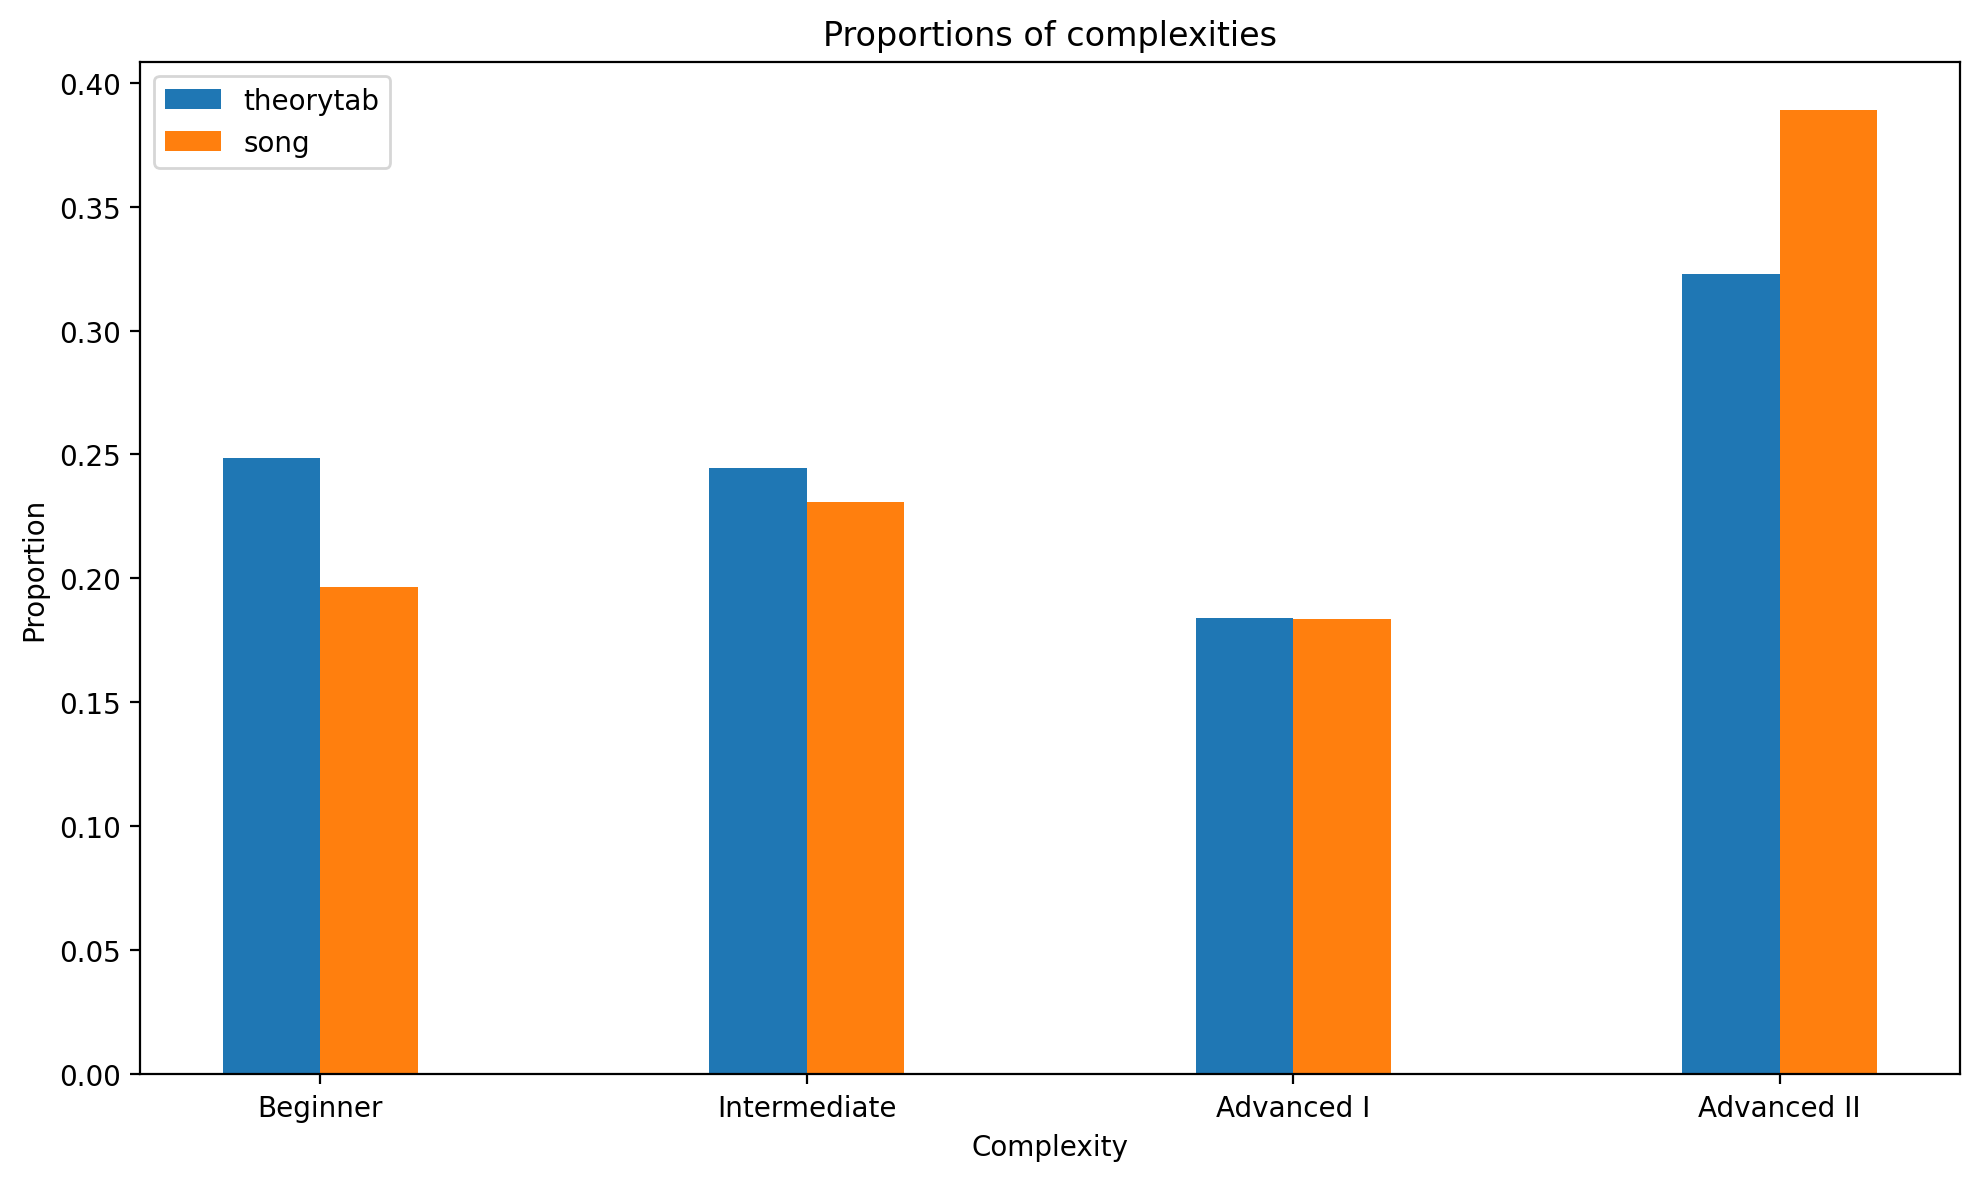

In [34]:
# Labels for sets and levels
sets = ['theorytab', 'song']

to_plot = [
    list(zip(theorytab_complexities, theorytab_complexities_proportion)),
    list(zip(song_complexities, song_complexities_proportion))
]

# Rearranging the data to group by set (Train, Validation, Test) instead of level
grouped_values = {set_name: [group[i][1] for i in range(len(COMPLEXITIES))] for set_name, group in zip(sets, to_plot)}

# Bar plot parameters
x = np.arange(len(COMPLEXITIES))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for i, (set_name, y) in enumerate(grouped_values.items()):
    ax.bar(x + i*width - width / 2, y, width, label=set_name)

ax.set_xlabel('Complexity')
ax.set_ylabel('Proportion')
ax.set_title('Proportions of complexities')
ax.set_xticks(x)
ax.set_xticklabels(COMPLEXITIES)
ax.legend()
plt.tight_layout()
plt.show()

# Saving dataset

In [35]:
with open(THEORYTAB_DATASET_FILEPATH, 'w') as fp:
    json.dump(theorytab_dataset, fp, indent=2)